In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import scipy.signal as signal

In [2]:
plt.style.use('notebook')

In [3]:
tin = Table.read('../data/aguirre.txt', format='ascii')

In [5]:
i0 = 2
t = Table.read('../data/bulk/lc_tic_{:09d}.fits'.format(tin['TIC'][i0]))

In [54]:
sec = np.unique(t['sector_id'])
ind_clip = np.zeros(len(t), dtype='bool')

for s in sec:
    ind = t['sector_id']==s
    ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<0.0005
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
tm = t['t'][ind_clip]
fm = t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])

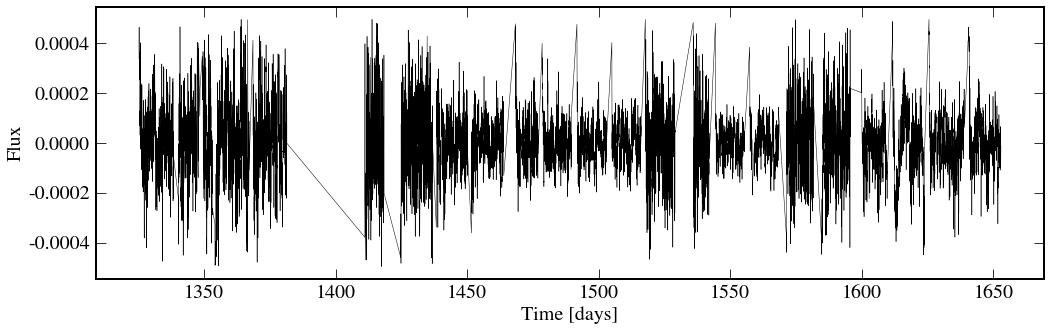

In [57]:
plt.figure(figsize=(15,5))
plt.plot(tm, fm, 'k-', lw=0.5)

# plt.axhline(0.0005, color='r')
# plt.axhline(-0.0005, color='r')
plt.xlabel('Time [days]')
plt.ylabel('Flux')

plt.tight_layout()
plt.savefig('../plots/lc_tic_{:09d}.png'.format(tin['TIC'][i0]))

In [87]:
# freq = np.logspace(-3,0,1000)
Nfreq = 1000
freq = np.linspace(1,200,Nfreq)
frlin = (freq / (2*np.pi) * u.day**-1).to(u.uHz)

In [88]:
pgram = signal.lombscargle(tm, fm, freq, normalize=True)

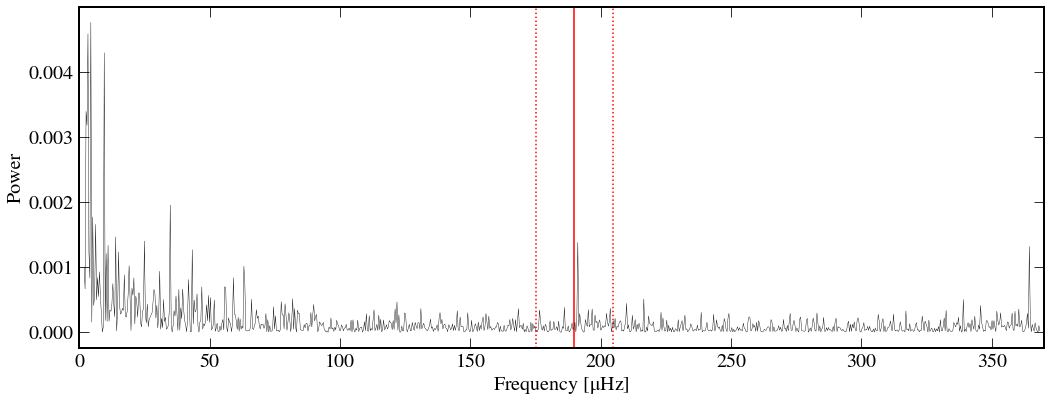

In [89]:
plt.figure(figsize=(15,6))
plt.plot(frlin, pgram, 'k-', lw=0.4, zorder=10)
plt.axvline(tin['numax'][i0], color='r')
plt.axvline(tin['numax'][i0]-tin['Delnu'][i0], color='r', ls=':')
plt.axvline(tin['numax'][i0]+tin['Delnu'][i0], color='r', ls=':')

plt.xlim(0,370)
plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Power')

plt.tight_layout()
plt.savefig('../plots/lsp_tic_{:09d}_{:06d}.png'.format(tin['TIC'][i0], Nfreq))

## Aguirre catalog

In [43]:
tlist = []

for i in range(len(tin)):
    t = Table.read('../data/bulk/lc_tic_{:09d}.fits'.format(tin['TIC'][i]))
    tlist += [t]

In [52]:
print(np.min(tin['numax']), np.max(tin['numax']))

27.6 189.9


In [57]:
freq = np.linspace(1,200,2000)
frlin = (freq / (2*np.pi) * u.day**-1).to(u.uHz)

In [58]:
print(np.min(frlin), np.max(frlin))

1.8420711006006407 uHz 368.4142201201281 uHz


In [66]:
tm = []
fm = []

for t in tlist:
    sec = np.unique(t['sector_id'])
    ind_clip = np.zeros(len(t), dtype='bool')
    for s in sec:
        ind = t['sector_id']==s
        ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<1
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
    tm += [t['t'][ind_clip]]
    fm += [t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])]

In [67]:
for i in range(24):
    print(i, np.std(fm[i]))

0 0.00039136693901203467
1 0.0005610105628048978
2 0.001759145236469796
3 0.00010071831130518987
4 0.0006347431291776873
5 0.0002347571878613776
6 0.0001907553631862418
7 0.00015741756976958777
8 0.0002725605511917401
9 0.0001254386298708227
10 0.0006021414195221096
11 0.001001914672191336
12 0.00027808020006132633
13 0.0006537621378954884
14 0.0003879078229111412
15 0.00010488601149473809
16 0.0005834544979139236
17 0.00016378453295058532
18 0.00015385064929936482
19 0.00014100850965994256
20 0.00029004918001995447
21 0.00043441588348781124
22 0.0007513064774752455
23 0.08049774245465456


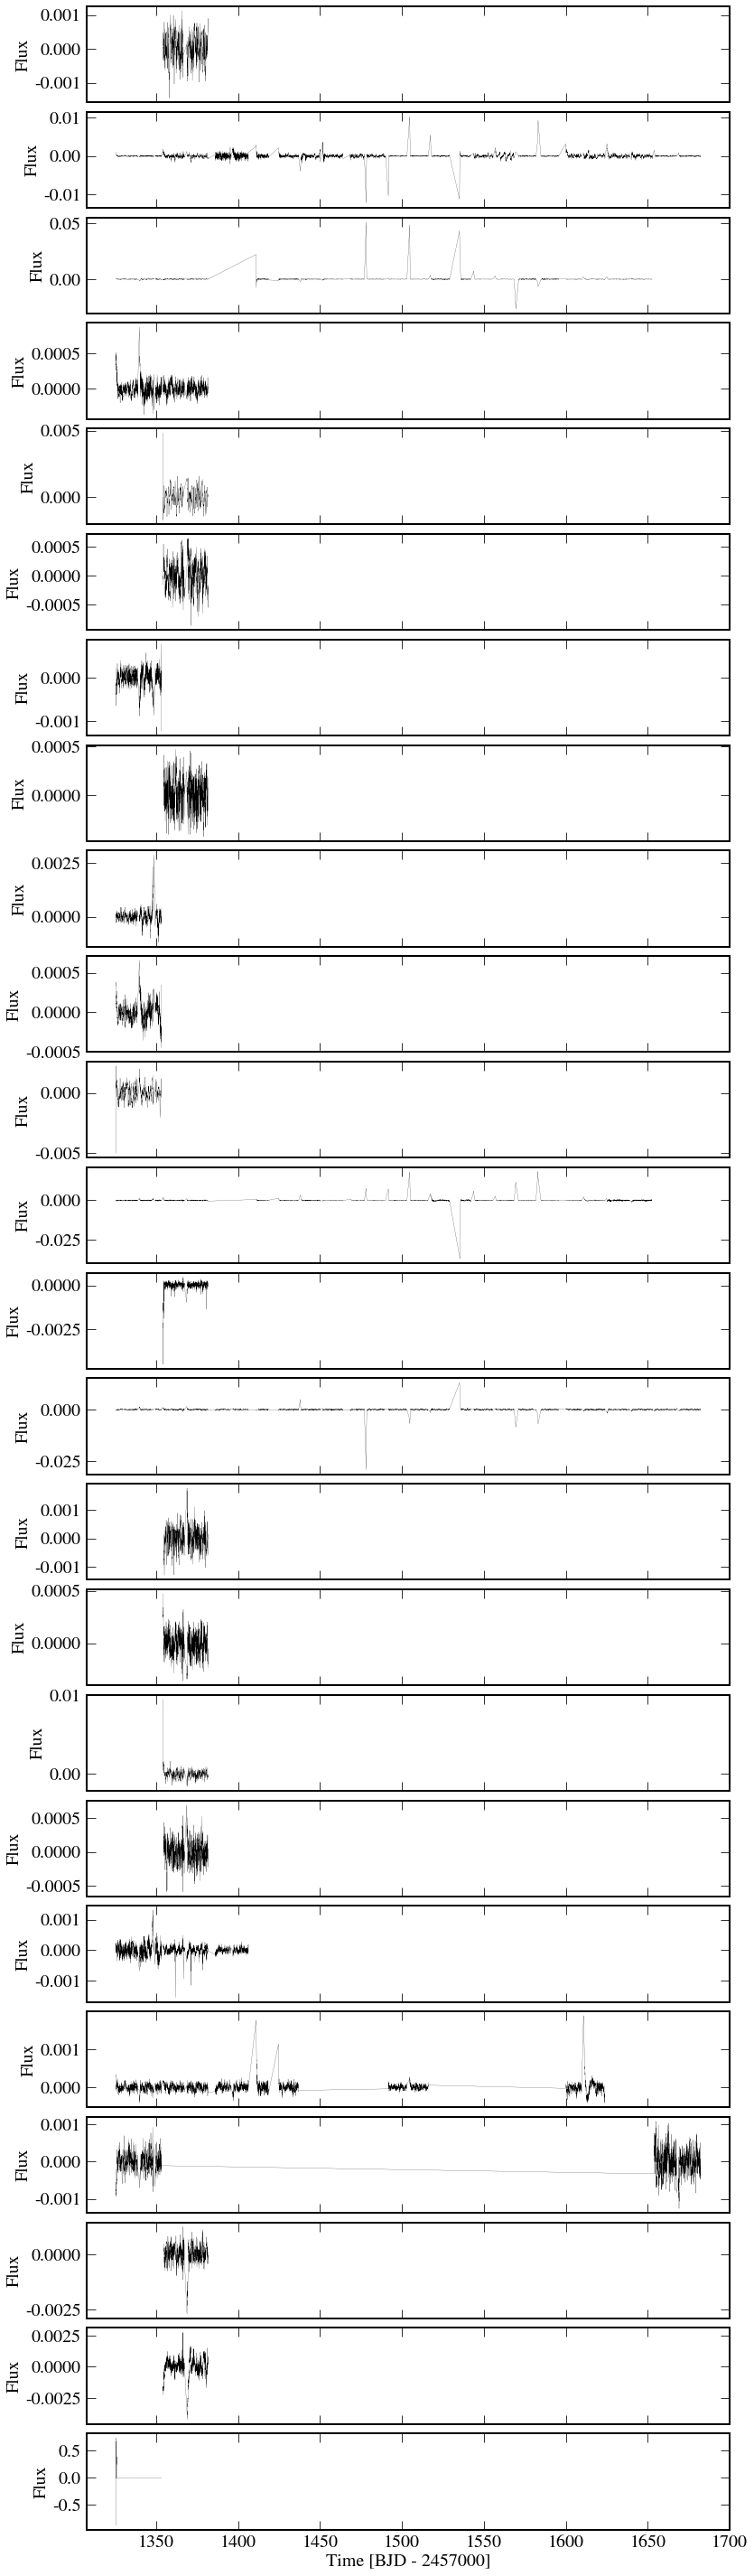

In [68]:
fig, ax = plt.subplots(24,1,figsize=(12,40), sharex=True)

for i in range(24):
    plt.sca(ax[i])
    plt.plot(tm[i], fm[i], 'k-', lw=0.2)
    plt.ylabel('Flux')
#     plt.ylim(-0.0019,0.0019)

plt.xlabel('Time [BJD - 2457000]')

plt.tight_layout(h_pad=0)

In [61]:
pgram = []

for i in range(24):
    p_ = signal.lombscargle(tm[i], fm[i], freq, normalize=True)
    pgram += [p_]

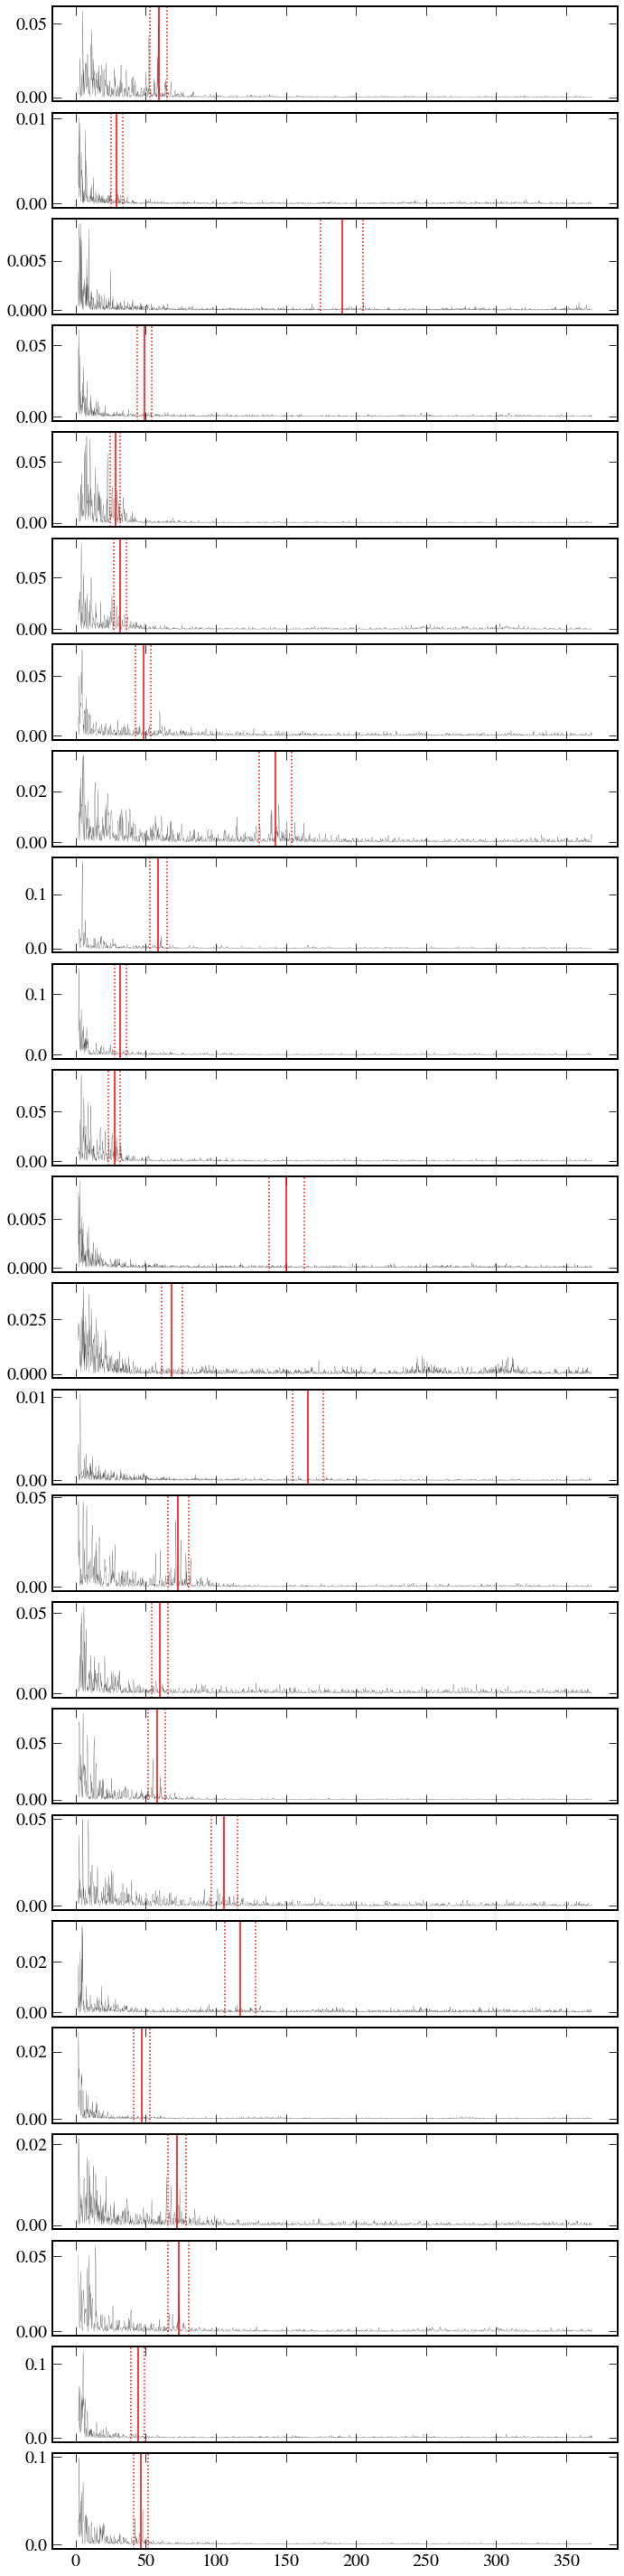

In [62]:
fig, ax = plt.subplots(24,1,figsize=(10,40), sharex=True)

for i in range(24):
    plt.sca(ax[i])
    
    plt.plot(frlin, pgram[i], 'k-', lw=0.2)
    
    plt.axvline(tin['numax'][i], color='r')
    plt.axvline(tin['numax'][i]-tin['Delnu'][i], color='r', ls=':')
    plt.axvline(tin['numax'][i]+tin['Delnu'][i], color='r', ls=':')
    
# plt.xlim(0,600)
plt.tight_layout(h_pad=0)

In [3]:
tlist = []

for i in range(10):
    t = Table.read('../data/bulk/lc_{:04d}.fits'.format(i))
    tlist += [t]

In [4]:
tm = []
fm = []

for t in tlist:
    sec = np.unique(t['sector_id'])
    ind_clip = np.zeros(len(t), dtype='bool')
    for s in sec:
        ind = t['sector_id']==s
        ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<0.002
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
    tm += [t['t'][ind_clip]]
    fm += [t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])]
    
#     tm += [t['t']]
#     fm += [t['fnorm'] - np.mean(t['fnorm'])]

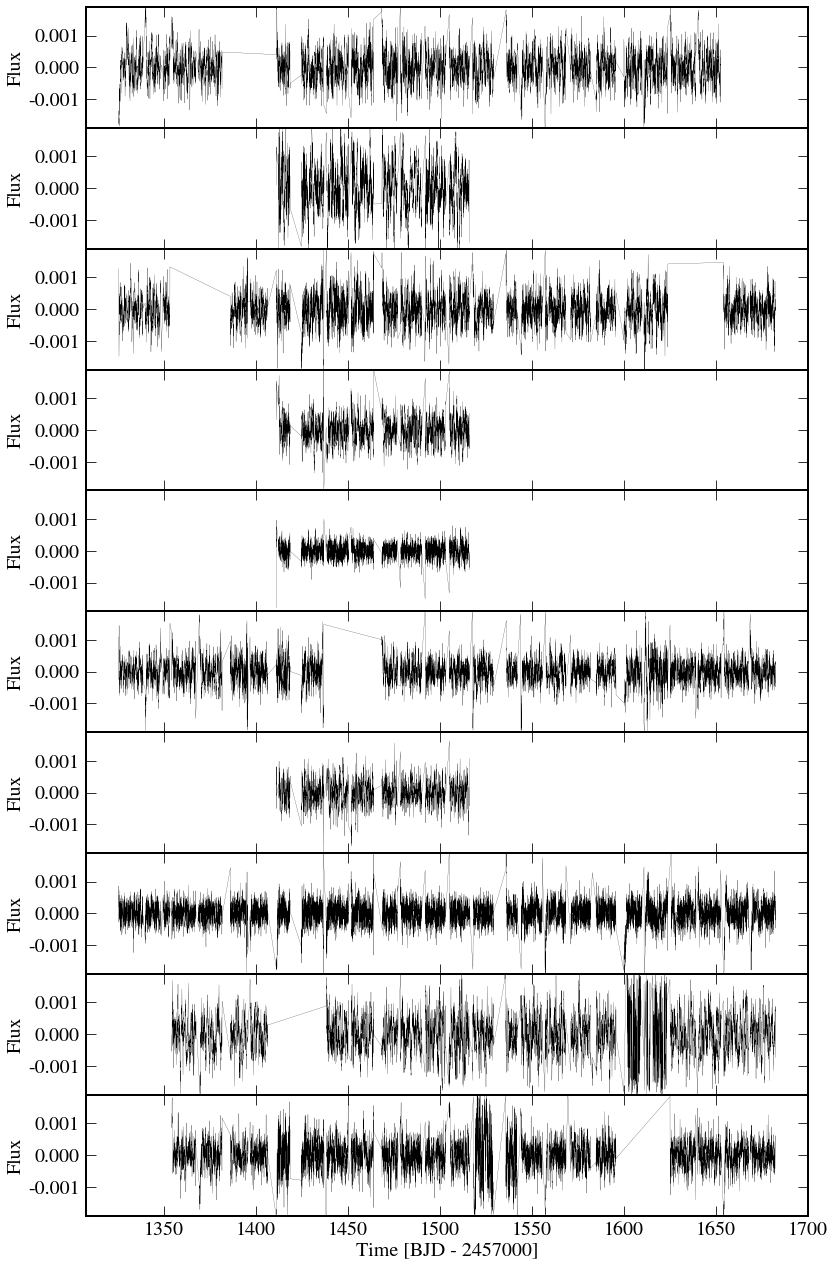

In [5]:
fig, ax = plt.subplots(10,1,figsize=(12,18), sharex=True, sharey=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(tm[i], fm[i], 'k-', lw=0.2)
    plt.ylabel('Flux')
    plt.ylim(-0.0019,0.0019)

plt.xlabel('Time [BJD - 2457000]')

plt.tight_layout(h_pad=0)

In [11]:
freq = np.linspace(0.1,60,2000)
fr = (freq/u.day).to(u.microhertz)

In [12]:
pgram = []

for i in range(10):
    p_ = signal.lombscargle(tm[i], fm[i], freq, normalize=True)
    pgram += [p_]

In [28]:
# find numax
numax = np.empty(10)*u.uHz
nutop = 60*u.uHz

for i in range(10):
    ind_max = np.argmax(pgram[i][fr<nutop])
    numax[i] = fr[fr<nutop][ind_max]

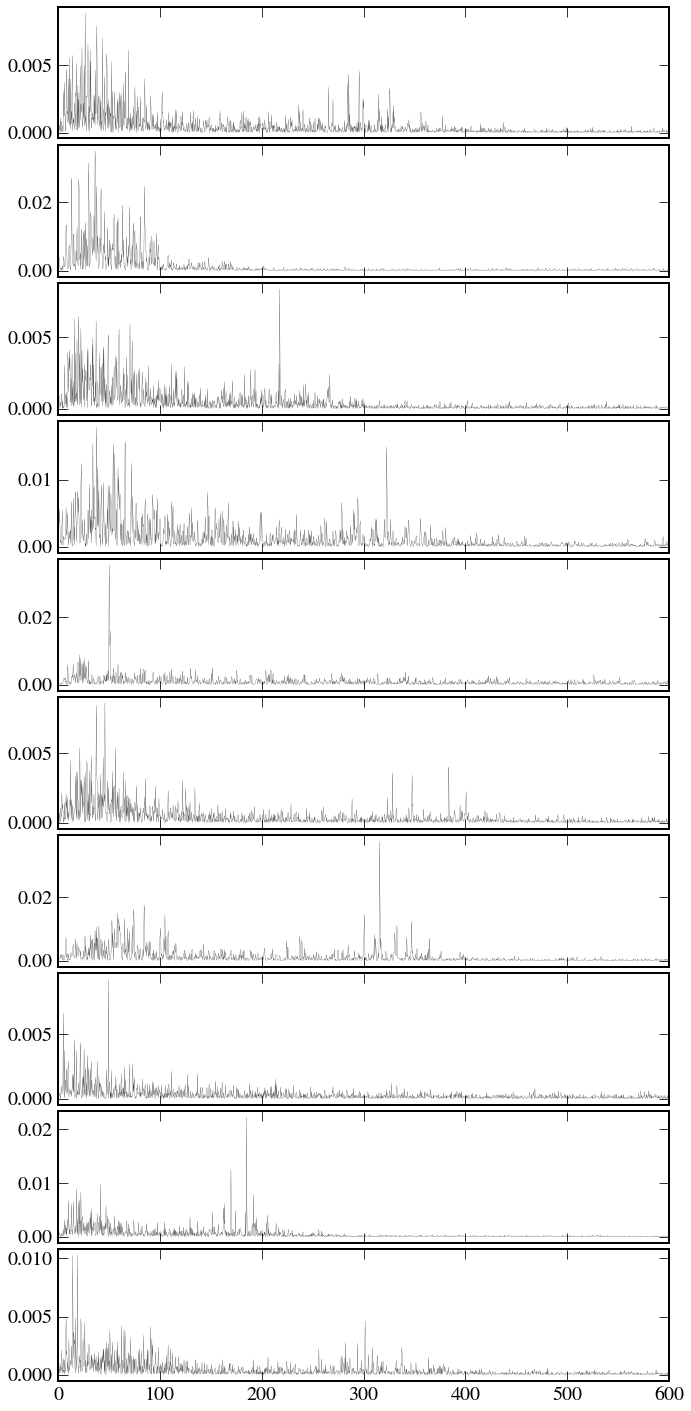

In [15]:
fig, ax = plt.subplots(10,1,figsize=(10,20), sharex=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(fr, pgram[i], 'k-', lw=0.2)
    
plt.xlim(0,600)
plt.tight_layout(h_pad=0)

In [16]:
g = Table.read('../data/giants.fits')

In [17]:
distance = 1/g['parallax'] * u.kpc / u.mas
dm = 5*np.log10(distance.to(u.pc).value) - 5
G = g['phot_g_mean_mag'] - dm
G0 = G - np.nanmedian(g['a_g_val'])
# G0 = G - g['a_g_val']

/usr/lib64/python3.6/site-packages/numpy/lib/function_base.py:3523: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


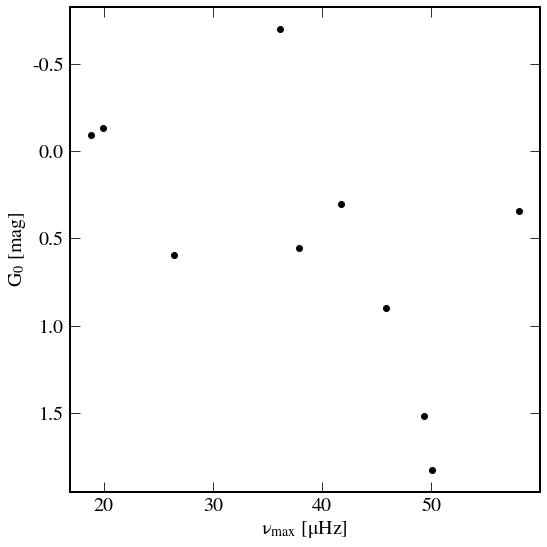

In [29]:
plt.plot(numax, G0[:10], 'ko')

plt.gca().invert_yaxis()
# plt.gca().set_xscale('log')
plt.xlabel('$\\nu_{max}$ [$\mu$Hz]')
plt.ylabel('G$_0$ [mag]')
plt.tight_layout()